In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm

In [3]:
#load data
walk1 = pd.read_csv('./data/walk1.csv')
walk2 = pd.read_csv('./data/walk2.csv')
run = pd.read_csv('./data/run.csv')
stairs = pd.read_csv('./data/stairs.csv')
relaxed = pd.read_csv('./data/relaxed.csv')


In [4]:
def clean_data(df, activity):
    '''
    This function cleans the data by:
    1. Drop columns with all missing values
    2. Convert datetime to date column and time column separately
    3. Drop the original datetime column
    4. Drop Time (s) column followed by dot and a number
    5. Create a new column for activity

    Parameters:
    df: pandas dataframe
    activity: string

    Returns:
    df: cleaned pandas dataframe 
    '''
    df = df.copy()
    # Drop columns with all missing values
    df.dropna(axis=1, how='all', inplace=True)
    # Convert datetime to date column and time column separately
    df['Date'] = pd.to_datetime(df['Actual System Time Text']).dt.date
    df['Time'] = pd.to_datetime(df['Actual System Time Text']).dt.time
    # Drop the original datetime column
    df.drop(columns=['Actual System Time Text', 'Actual System Time', 'Time (s)'], inplace=True)
    # Drop Time (s) column followed by dot and a number
    df = df[df.columns.drop(list(df.filter(regex='Time \(s\)\.\d+')))]
    # Create a new column for activity
    df['Activity'] = activity
    #if activity is walking, drop the Latitude (°)	Longitude (°)	Height (m)	Velocity (m/s)	Direction (°)	Horizontal Accuracy (m)	Vertical Accuracy (m) columns
    if activity == 'walking':
        df.drop(columns=['Latitude (°)', 'Longitude (°)', 'Height (m)', 'Velocity (m/s)', 'Direction (°)', 'Horizontal Accuracy (m)', 'Vertical Accuracy (m)'], inplace=True) 
    #if the activity is relaxed change the date to 2024-05-17
    if 'relaxed' in df['Activity'].values:
        new_start_time = pd.Timestamp('2024-05-17 15:34:25.868713140')

        # Combine Date and Time columns into a single datetime column
        df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

        # Filter the dataset based on the activity
        df_activity = df[df['Activity'] == activity].copy()

        # Adjust the times
        if not df_activity.empty:
            first_time = df_activity['DateTime'].iloc[0]
            df_activity['DateTime'] = new_start_time + (df_activity['DateTime'] - first_time)

            # Split DateTime back into Date and Time
            df_activity['Date'] = df_activity['DateTime'].dt.date
            df_activity['Time'] = df_activity['DateTime'].dt.time
            df_activity.drop(columns=['DateTime'], inplace=True)

        # Update the original dataframe with the adjusted times
        df.update(df_activity)
        
    return df

<>:26: SyntaxWarning: invalid escape sequence '\('
<>:26: SyntaxWarning: invalid escape sequence '\('
C:\Users\Lia\AppData\Local\Temp\ipykernel_18020\2111381136.py:26: SyntaxWarning: invalid escape sequence '\('
  df = df[df.columns.drop(list(df.filter(regex='Time \(s\)\.\d+')))]


In [5]:
walk1_df = clean_data(walk1,'walking')
walk2_df = clean_data(walk2,'walking')
run_df = clean_data(run,'running')
stairs_df = clean_data(stairs,'stairs')
relaxed_df = clean_data(relaxed,'relaxed')

In [6]:
walk1_df['Source'] = 'walking_1'
walk2_df['Source'] = 'walking_2'
run_df['Source'] = 'runnning'
stairs_df['Source'] = 'stairs'
relaxed_df['Source'] = 'relaxed'

#concatenate all dataframes and sort by date and time
df = pd.concat([walk1_df, walk2_df, run_df, stairs_df, relaxed_df])
#drop the DateTime column
df = df.drop(columns=['DateTime'])
df = df.sort_values(by=['Date', 'Time'])
#reset index
df = df.reset_index(drop=True)
#save the cleaned data to a csv file
df.to_csv('./data/all_data.csv', index=False)

In [7]:
all_data = pd.read_csv('./data/all_data.csv')
all_data.head()

,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Illuminance (lx),Date,Time,Activity,Source
0,-3.141193,2.638410,8.540117,-0.043371,0.065973,0.091019,48.0,2024-05-17,13:59:37.034873,walking,walking_1
1,-3.337517,2.734178,8.322245,-0.043371,0.065973,0.091019,47.0,2024-05-17,13:59:37.045433,walking,walking_1
2,-3.445256,2.743755,8.243237,-0.043371,0.065973,0.091019,46.0,2024-05-17,13:59:37.055443,walking,walking_1
3,-3.545813,2.695871,8.339005,-0.043371,0.065973,0.091019,45.0,2024-05-17,13:59:37.065453,walking,walking_1
4,-3.591303,2.657564,8.640674,-1.258382,0.047647,0.166155,44.0,2024-05-17,13:59:37.075432,walking,walking_1


In [8]:
def add_heart_rate(df):
    '''
    Function that adds heart rate data to the dataframe given the activity type.

    Parameters:
    df: pandas dataframe

    Returns:
    df: pandas dataframe with heart rate data added 
    '''
    df = df.copy()
    
    
    # Extract only the minute part for resampling
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Second'] = df['Timestamp'].dt.floor('s')

    # Generate heart rate data for each minute
    heart_rate_data = []
    for second in df['Second'].unique():
        activities_in_second = df[df['Second'] == second]['Activity'].unique()
        for activity in activities_in_second:
            if activity == 'walking':
                heart_rate = np.random.randint(80, 110)
            elif activity == 'running':
                heart_rate = np.random.randint(120, 150)
            elif activity == 'stairs':
                heart_rate = np.random.randint(100, 140)
            elif activity == 'relaxed':
                heart_rate = np.random.randint(60, 90)
            heart_rate_data.append({'Second': second, 'Activity': activity, 'Heart Rate (bpm)': heart_rate})

    # Create a DataFrame from the heart rate data
    heart_rate_df = pd.DataFrame(heart_rate_data)

    # Merge the heart rate data back into the original DataFrame
    df = pd.merge(df, heart_rate_df, on=['Second', 'Activity'], how='left')

    # Set heart rate values to None except for the first record of each minute
    df['Heart Rate (bpm)'] = df.groupby('Second')['Heart Rate (bpm)'].transform(lambda x: x.where(x.index == x.index[0], None))

    # Drop the Minute column
    df.drop(columns=['Second'], inplace=True)
 
    return df

In [14]:
def aggregate(final_all_data):
    '''
    Function that aggregates the data by resampling the numerical columns to 100ms and the Activity column to mode.

    Parameters:
    final_all_data: pandas dataframe

    Returns:
    resampled_data: pandas dataframe with aggregated data
    '''
    final_all_data['Timestamp'] = pd.to_datetime(final_all_data['Date'] + ' ' + final_all_data['Time'])

    # Set the Timestamp as the index
    final_all_data.set_index('Timestamp', inplace=True)

    # Drop the original Date and Time columns as they are now redundant
    final_all_data.drop(columns=['Date', 'Time'], inplace=True)
    numerical_columns = final_all_data.select_dtypes(include=['float64', 'int64']).columns
    activity_column = 'Activity'
    source_column = 'Source'

    # Resample numerical columns by taking the mean
    resampled_numerical = final_all_data[numerical_columns].resample('100ms').mean()

    # Resample the Activity column by taking the mode
    resampled_activity = final_all_data[activity_column].resample('100ms').apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    resampled_source = final_all_data[source_column].resample('100ms').apply(lambda x: x.mode()[0] if not x.mode().empty else None)

    # Combine the resampled numerical data and the Activity column
    resampled_data = pd.concat([resampled_numerical, resampled_activity, resampled_source], axis=1)

    # Drop rows with all missing values
    resampled_data.dropna(subset=['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'])

    # Save the resampled data to a new CSV file
    output_path = './data/aggregated_data.csv'
    resampled_data.to_csv(output_path)

In [15]:
data = pd.read_csv('./data/all_data.csv')
aggregate(data)

In [16]:
#Load the aggregated data
aggregated_data = pd.read_csv('./data/aggregated_data.csv')
final_data = add_heart_rate(aggregated_data)
#save the final data to a csv file
final_data.to_csv('./data/final_data.csv', index=False)
final_data.head()

,Timestamp,Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s),Illuminance (lx),Activity,Source,Heart Rate (bpm)
0,2024-05-17 13:59:37.000,-3.420972,2.675691,8.604419,-0.272708,-0.055938,0.108734,45.571429,walking,walking_1,88.0
1,2024-05-17 13:59:37.100,-2.785414,2.516785,9.533711,-0.050396,-0.243247,0.154549,54.500000,walking,walking_1,NaN
2,2024-05-17 13:59:37.200,-2.401145,2.601779,9.402748,0.024251,-0.297064,0.217163,50.100000,walking,walking_1,NaN
3,2024-05-17 13:59:37.300,-1.852633,2.452620,9.426451,0.075075,-0.044227,0.393336,57.000000,walking,walking_1,NaN
4,2024-05-17 13:59:37.400,-1.564371,2.317587,9.644802,-0.019548,-0.074098,0.662544,53.000000,walking,walking_1,NaN


c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

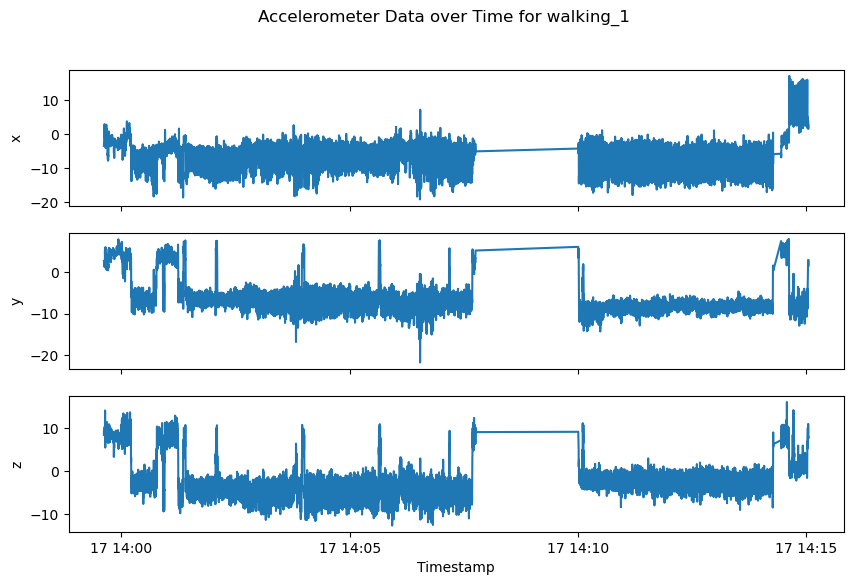

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

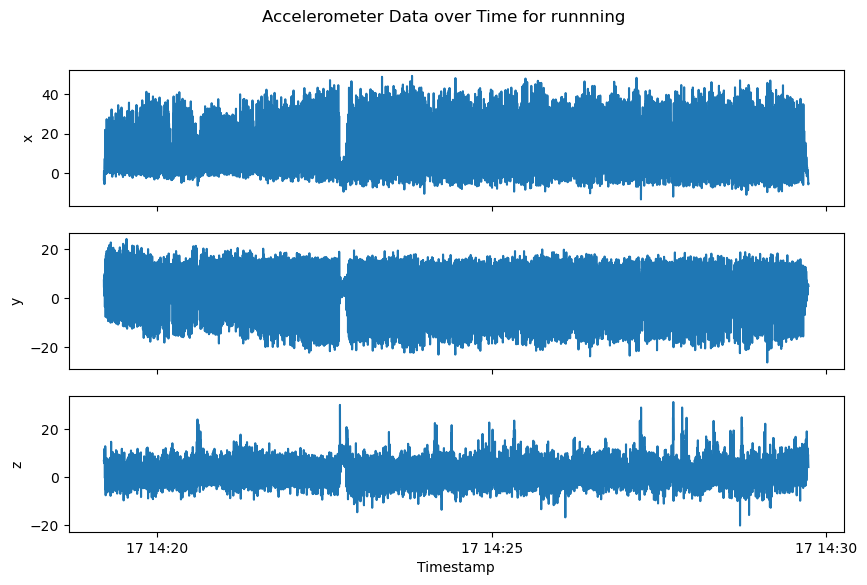

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

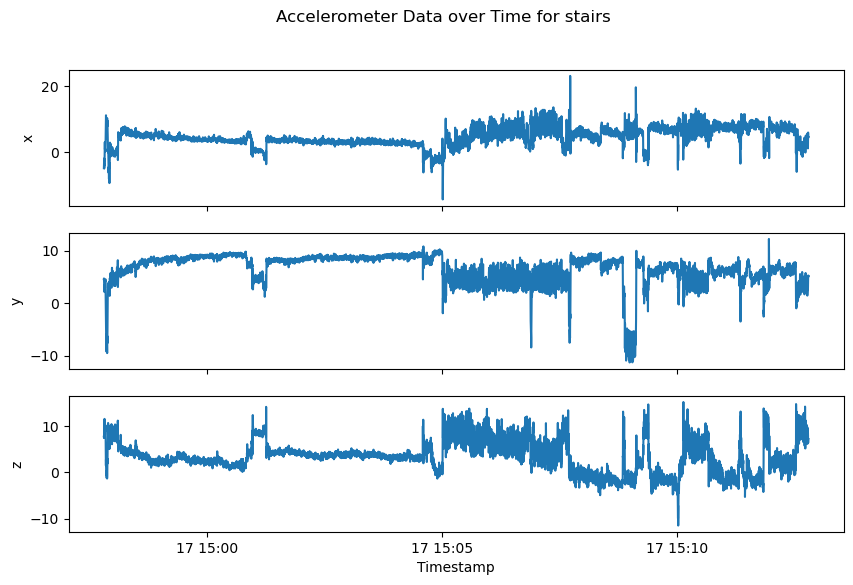

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

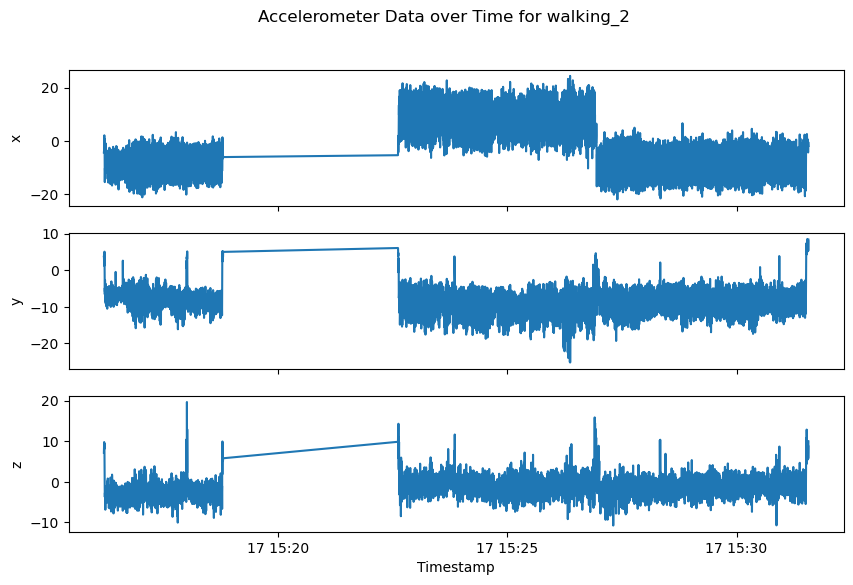

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

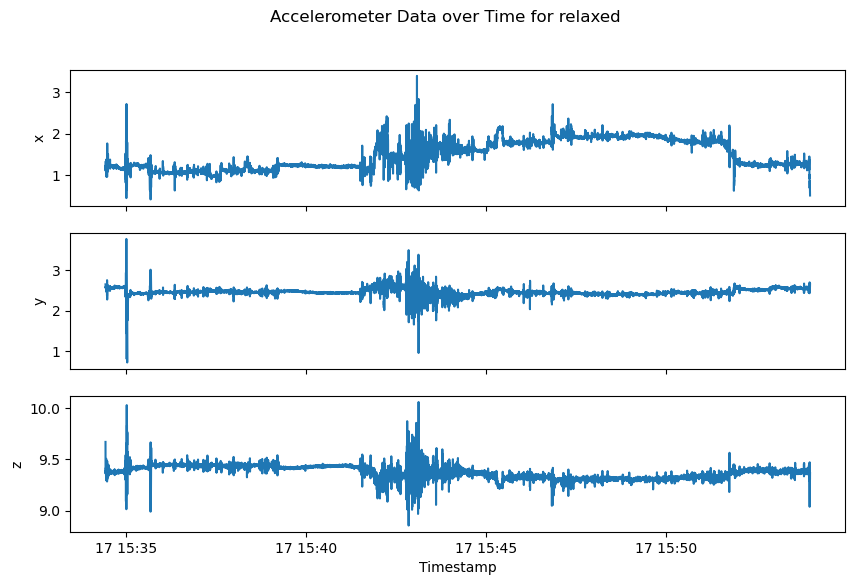

In [17]:
df = pd.read_csv('./data/final_data.csv')
#drop the rows with all missing values
df = df.dropna(subset=['Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)'])
df.to_csv('./data/final_data.csv', index=False)

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Get the unique activities
activities = df['Source'].unique()

# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot accelerometer data
    fig, axs = plt.subplots(3, sharex=True, figsize=(10, 6))
    fig.suptitle(f'Accelerometer Data over Time for {activity}')
    sns.lineplot(ax=axs[0], data=activity_data, x='Timestamp', y='Acceleration x (m/s^2)')
    axs[0].set_ylabel('x')
    sns.lineplot(ax=axs[1], data=activity_data, x='Timestamp', y='Acceleration y (m/s^2)')
    axs[1].set_ylabel('y')
    sns.lineplot(ax=axs[2], data=activity_data, x='Timestamp', y='Acceleration z (m/s^2)')
    axs[2].set_ylabel('z')
    plt.show()

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

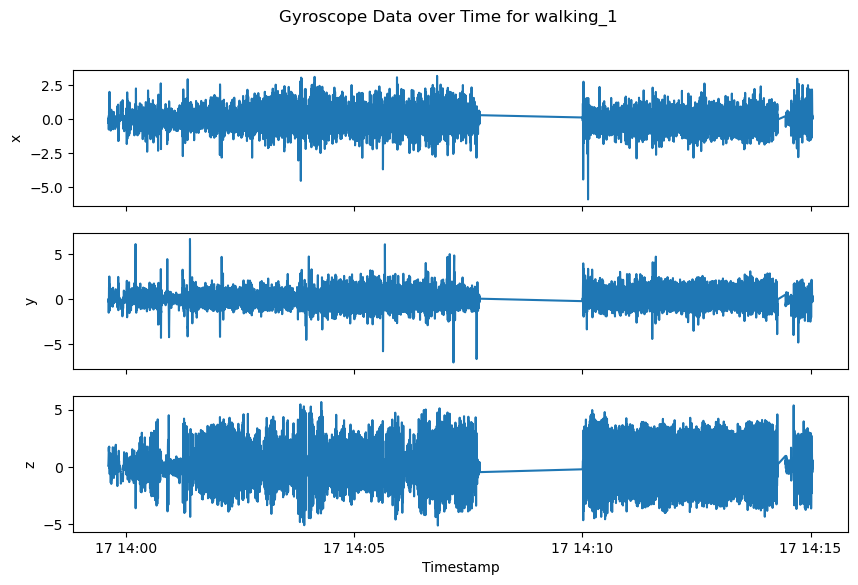

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

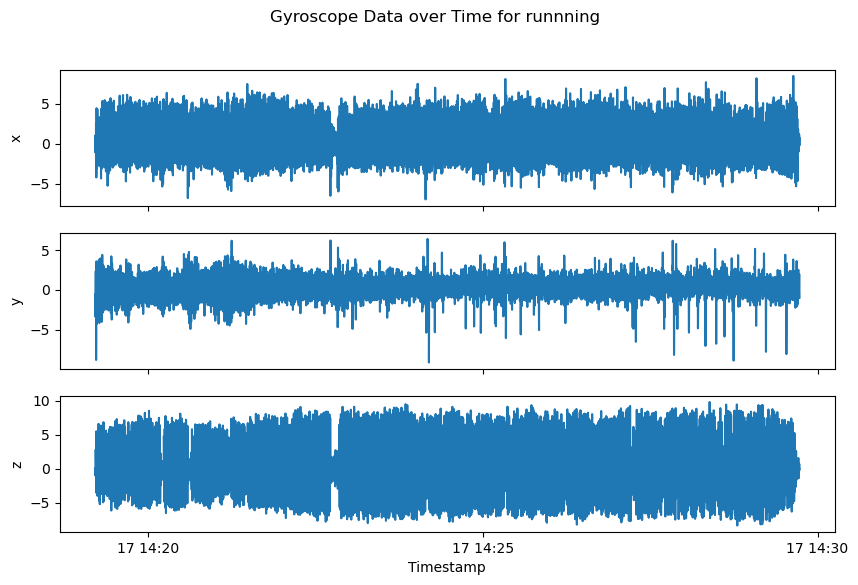

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

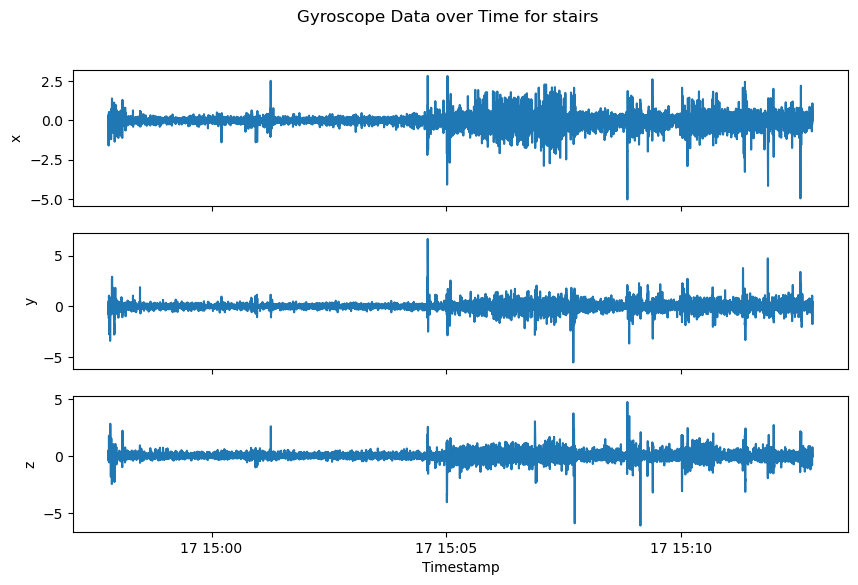

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

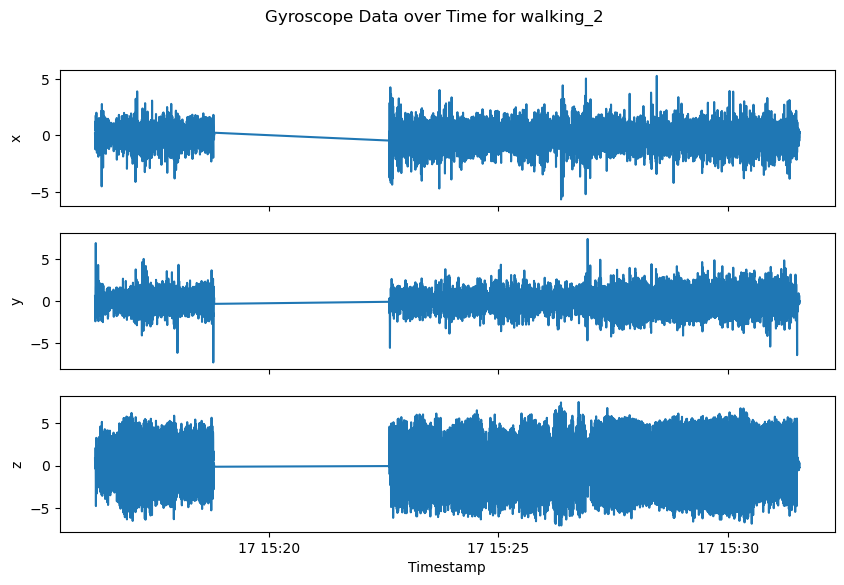

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

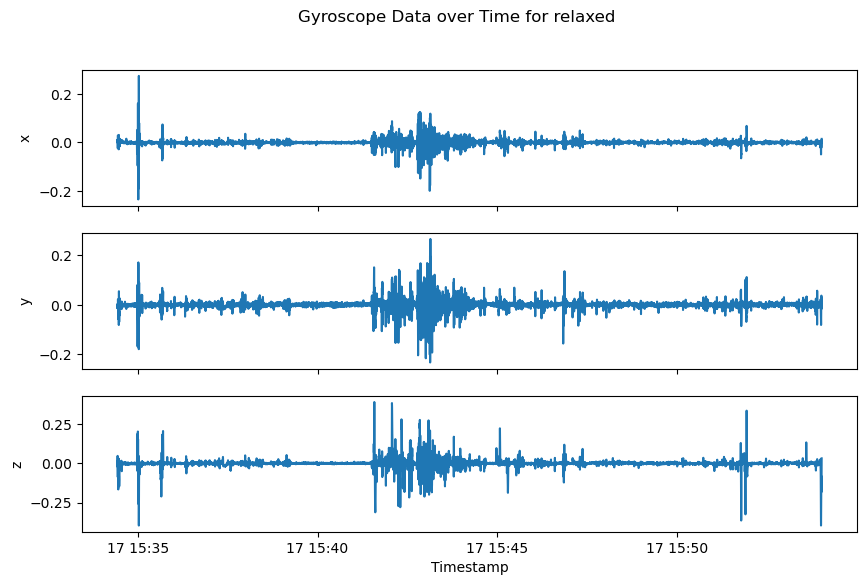

In [18]:
# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot gyroscope data
    fig, axs = plt.subplots(3, sharex=True, figsize=(10, 6))
    fig.suptitle(f'Gyroscope Data over Time for {activity}')
    sns.lineplot(ax=axs[0], data=activity_data, x='Timestamp', y='Gyroscope x (rad/s)')
    axs[0].set_ylabel('x')
    sns.lineplot(ax=axs[1], data=activity_data, x='Timestamp', y='Gyroscope y (rad/s)')
    axs[1].set_ylabel('y')
    sns.lineplot(ax=axs[2], data=activity_data, x='Timestamp', y='Gyroscope z (rad/s)')
    axs[2].set_ylabel('z')
    plt.show()

C:\Users\Lia\AppData\Local\Temp\ipykernel_18020\3213164083.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_spent = df.groupby('Source').apply(lambda x: (x['Timestamp'].max() - x['Timestamp'].min()).total_seconds() / 60)


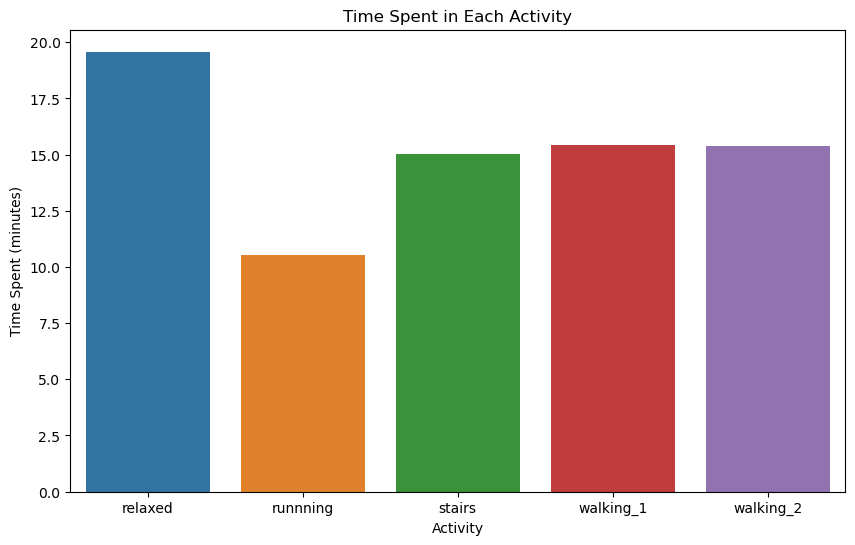

In [19]:
# Calculate the time spent in each activity
time_spent = df.groupby('Source').apply(lambda x: (x['Timestamp'].max() - x['Timestamp'].min()).total_seconds() / 60)

# Plot the time spent in each activity
plt.figure(figsize=(10, 6))
sns.barplot(x=time_spent.index, y=time_spent.values)
plt.title('Time Spent in Each Activity')
plt.xlabel('Activity')
plt.ylabel('Time Spent (minutes)')
plt.show()

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


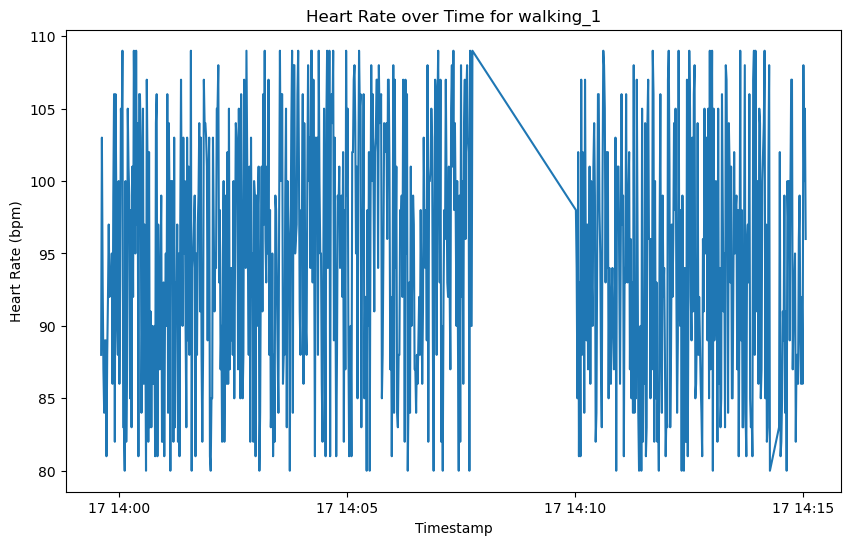

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


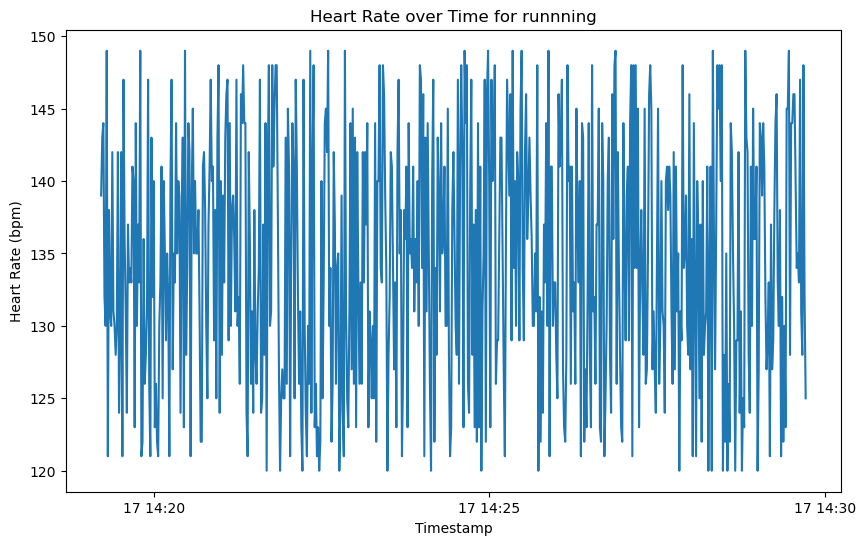

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


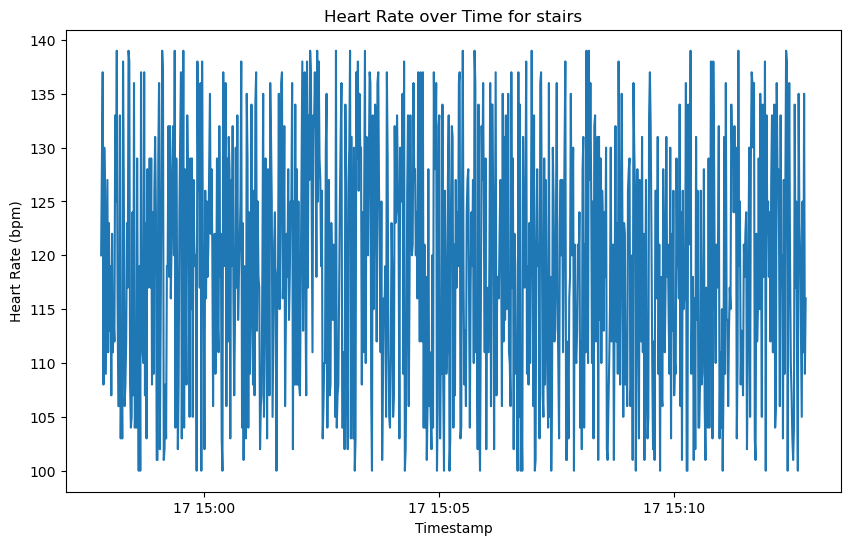

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


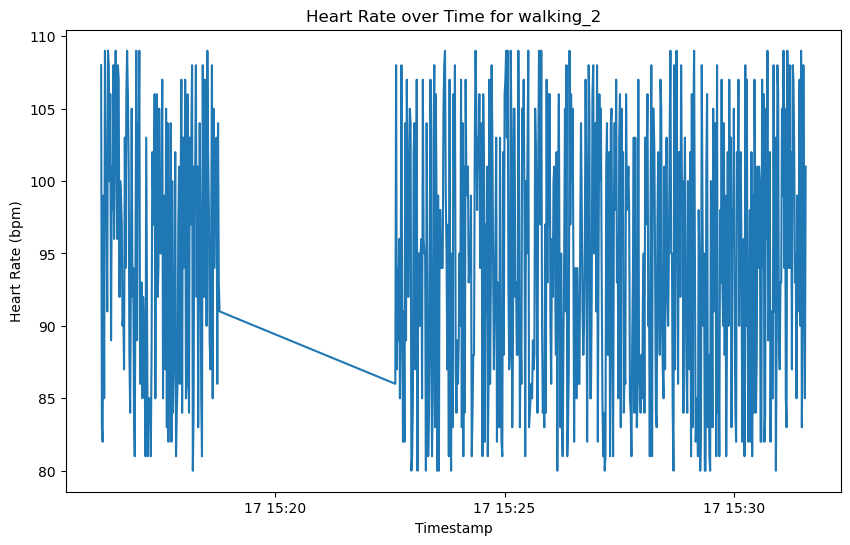

c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lia\miniconda3\envs\ML4QS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


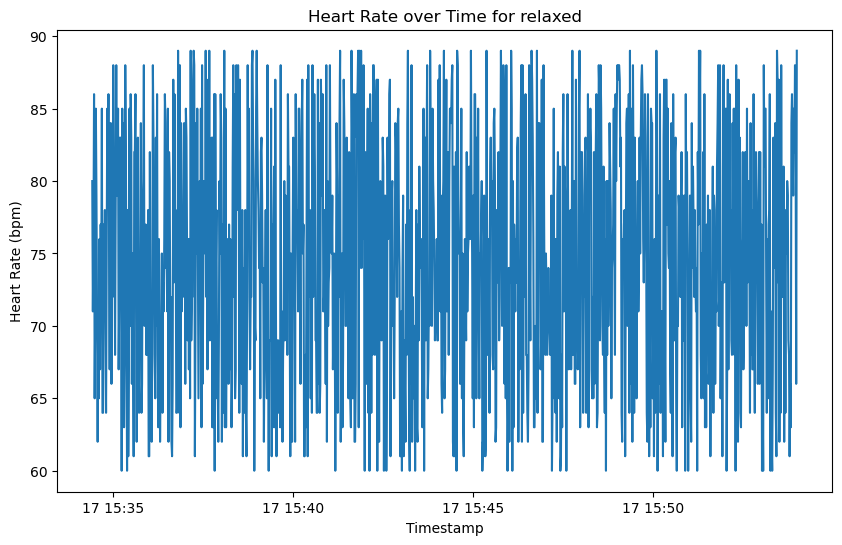

In [20]:
# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot heart rate over time
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=activity_data, x='Timestamp', y='Heart Rate (bpm)')
    plt.title(f'Heart Rate over Time for {activity}')
    plt.show()

In [21]:
def print_variable_stats_by_activity(df):
    '''
    Function to print the mean, min, max, and variance of each numeric column
    for each category of activity

    Parameters:
    df: pandas dataframe
    '''
    activity_column = 'Source'
    activities = df[activity_column].unique()
    
    for activity in activities:
        activity_df = df[df[activity_column] == activity]
        print(f'Statistics for activity: {activity}')
        print('-' * 40)
        
        for column in activity_df.columns:
            if pd.api.types.is_numeric_dtype(activity_df[column]) and column != activity_column:
                mean = activity_df[column].mean()
                min_value = activity_df[column].min()
                max_value = activity_df[column].max()
                variance = activity_df[column].var()
                
                print(f'Statistics for column: {column}')
                print(f'Mean: {mean}')
                print(f'Min: {min_value}')
                print(f'Max: {max_value}')
                print(f'Variance: {variance}')
                print('-' * 20)
        print('=' * 40)

In [22]:
# Print the statistics for each column
print_variable_stats_by_activity(df)

Statistics for activity: walking_1
----------------------------------------
Statistics for column: Acceleration x (m/s^2)
Mean: -6.204443515414718
Min: -19.135417272
Max: 17.120217990999997
Variance: 20.03817447204324
--------------------
Statistics for column: Acceleration y (m/s^2)
Mean: -6.325198335349076
Min: -21.739351653
Max: 7.9815500735
Variance: 17.473959366994066
--------------------
Statistics for column: Acceleration z (m/s^2)
Mean: -2.1214808450911287
Min: -12.7579826362
Max: 16.197014235
Variance: 19.99445697935668
--------------------
Statistics for column: Gyroscope x (rad/s)
Mean: -0.05683228418062017
Min: -5.8931392670000005
Max: 3.1697186826
Variance: 0.6397629675258619
--------------------
Statistics for column: Gyroscope y (rad/s)
Mean: 0.023071228381791646
Min: -7.0050361634
Max: 6.637845039299999
Variance: 1.058585991861341
--------------------
Statistics for column: Gyroscope z (rad/s)
Mean: -0.01975304235175372
Min: -5.1186231375
Max: 5.6671190738
Variance: 4.2

In [23]:
def chauvenet_criterion(df, column, c=2, remove=False):
    '''
    Function to detect outliers based on Chauvenet's criterion
    
    Parameters:
    df: pandas dataframe
    column: string, name of the column to detect outliers
    c: float, constant for Chauvenet's criterion
    remove: boolean, whether to remove the outliers
    
    Returns:
    df: pandas dataframe with outliers marked or removed
    '''
    N = len(df)
    mean = df[column].mean()
    std = df[column].std()
    
    # Calculate the probability threshold
    threshold = 1 / (c * N)
    
    # Calculate the Z-scores
    df.loc[:, 'z_score'] = (df[column] - mean) / std
    
    # Calculate the cumulative distribution function (CDF) values
    df.loc[:, 'cdf'] = norm.cdf(df['z_score'])
    
    # Identify outliers based on Chauvenet's criterion
    df.loc[:, 'outlier'] = (df['cdf'] < threshold) | ((1 - df['cdf']) < threshold)
    
    # Count the number of outliers
    num_outliers = df['outlier'].sum()
    
    # Print the number of outliers and the top 5 outlier values
    if num_outliers > 0:
        print(f'Number of outliers in {column}: {num_outliers}')
        top_outliers = df[df['outlier']][column].sort_values(ascending=False).head(5)
        print(f'Top 5 outliers in {column}:')
        print(top_outliers)
        print('-' * 40)
    else:
        print(f'No outliers detected in {column}.')
        print('-' * 40)
    
    if remove:
        # Filter out the outliers
        df = df[~df['outlier']]
    
    # Drop the auxiliary columns
    df.drop(columns=['z_score', 'cdf', 'outlier'], inplace=True)
    
    return df

In [24]:
def analyze_outliers_by_activity(df, remove=False):
    '''
    Function to detect outliers based on Chauvenet's criterion
    for each numeric column within each activity, and optionally remove them
    
    Parameters:
    df: pandas dataframe
    remove: boolean, whether to remove the outliers
    
    Returns:
    df: pandas dataframe with outliers marked or removed
    '''
    activity_column = 'Source'
    activities = df[activity_column].unique()
    
    cleaned_df = pd.DataFrame()
    
    for activity in activities:
        activity_df = df[df[activity_column] == activity].copy()
        print(f'Processing activity: {activity}')
        print('=' * 40)
        for column in activity_df.columns:
            if pd.api.types.is_numeric_dtype(activity_df[column]) and column != activity_column:
                activity_df = chauvenet_criterion(activity_df, column, remove=remove)
        cleaned_df = pd.concat([cleaned_df, activity_df])
    
    return cleaned_df

In [25]:
# Analyze outliers by activity without removing them
analyze_outliers_by_activity(df, remove=False)
print("outliers detected")

Processing activity: walking_1
Number of outliers in Acceleration x (m/s^2): 55
Top 5 outliers in Acceleration x (m/s^2):
9009    17.120218
9008    16.729484
9184    16.256151
9022    16.206591
9012    16.032532
Name: Acceleration x (m/s^2), dtype: float64
----------------------------------------
No outliers detected in Acceleration y (m/s^2).
----------------------------------------
Number of outliers in Acceleration z (m/s^2): 1
Top 5 outliers in Acceleration z (m/s^2):
8977    16.197014
Name: Acceleration z (m/s^2), dtype: float64
----------------------------------------
Number of outliers in Gyroscope x (rad/s): 12
Top 5 outliers in Gyroscope x (rad/s):
4322    3.169719
2712    3.099530
3795    3.067826
2535    3.042781
6305   -3.323657
Name: Gyroscope x (rad/s), dtype: float64
----------------------------------------
Number of outliers in Gyroscope y (rad/s): 34
Top 5 outliers in Gyroscope y (rad/s):
1074    6.637845
359     6.069924
3636    6.047749
1075    5.690515
358     5.160